In [1]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import math
import random
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
from statannot import add_stat_annotation
import seaborn as sns
import time
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import sklearn
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from lifelines import KaplanMeierFitter, CoxPHFitter, calibration
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
from scipy.stats import wilcoxon
import scipy.stats as st

In [2]:
risk_score = pd.read_csv('logs/results/SAGE256321e-06mean_ep3_val0.72_test0.753_exte0.67.csv')
external_risk_score = pd.read_csv('logs/results/SAGE256321e-06mean_ep3_val0.72_test0.753_exte0.67_EXTERNAL.csv')
resnet_risk_score = pd.read_csv('logs/results/ResNetSAGE256120mean_ep20_val0.713_test0.706_exte0.604.csv')
resnet_external_risk_score = pd.read_csv('logs/results/ResNetSAGE256120mean_ep20_val0.713_test0.706_exte0.604_EXTERNAL.csv')

In [3]:
print(external_risk_score['Age'].median())
print(external_risk_score['Age'].std())
data = risk_score['OS_Status'].to_list()
print(st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) )

69.0
9.105665481334853
(0.19855797585362825, 0.2378056605100081)


In [4]:
rfs = []
for i in range(len(external_risk_score['RFS_Status'])):
    if external_risk_score['OS_Status'][i] == 1 and external_risk_score['RFS_Status'][i] == 0:
        rfs.append(1)
    else:
        rfs.append(external_risk_score['RFS_Status'][i])

In [5]:
external_risk_score['new_RFS'] = rfs

In [6]:
train_id = np.load("data_ind/train_index.npy",allow_pickle=True)
val_id = np.load("data_ind/val_index.npy", allow_pickle=True)
test_id = np.load("data_ind/test_index.npy",allow_pickle=True)

print("training OS distribution:")
print(risk_score.iloc[train_id,:]['OS_Status'].value_counts())
print("validation OS distribution:")
print(risk_score.iloc[val_id,:]['OS_Status'].value_counts())
print("test OS distribution:")
print(risk_score.iloc[test_id,:]['OS_Status'].value_counts())


print("training RFS_Status distribution:")
print(risk_score.iloc[train_id,:]['RFS_Status'].value_counts())
print("validation RFS_Status distribution:")
print(risk_score.iloc[val_id,:]['RFS_Status'].value_counts())
print("test RFS_Status distribution:")
print(risk_score.iloc[test_id,:]['RFS_Status'].value_counts())
print("External RFS_Status distribution:")

print(external_risk_score['RFS_Status'].value_counts())

training OS distribution:
0    991
1    287
Name: OS_Status, dtype: int64
validation OS distribution:
0    173
1     41
Name: OS_Status, dtype: int64
test OS distribution:
0    169
1     44
Name: OS_Status, dtype: int64
training RFS_Status distribution:
0    931
1    347
Name: RFS_Status, dtype: int64
validation RFS_Status distribution:
0    158
1     56
Name: RFS_Status, dtype: int64
test RFS_Status distribution:
0    154
1     59
Name: RFS_Status, dtype: int64
External RFS_Status distribution:
0    113
1     46
Name: RFS_Status, dtype: int64


In [7]:
# define similarity of two patient
def SimScore(a1,a2,s1,s2,l1,l2,h1,h2,t1,t2,n1,n2,m1,m2,tnm1,tnm2): 
    c_score = 0
    h_score = 0
    l_score = 0
    t_score = 0

    # sex and age
    if s1 == s2:
        c_score +=1
    if abs(a1-a2) <= 5:
        c_score +=1  
    if l1 == l2:
        l_score +=1       
    if h1 == h2:
        h_score +=1
    if t1 == t2:
        t_score +=1
    if n1 == n2:
        t_score +=1 
    if m1 == m2:
        t_score +=1

    return c_score*t_score*h_score*l_score, c_score, t_score, h_score, l_score


def adj_matrix(patient_info):
    age = patient_info['Age'].to_list()
    sex = patient_info['Sex_1_male_2_female'].to_list()
    loc = patient_info['Location_1_LUL_2_LLL_3_RUL_4_RML_5_RLL'].to_list()
    his = patient_info['Histology_1_Adenocarcinoma_2_SquamousCellCarcinoma_3_Others'].to_list()
    pts = patient_info['pT_Stage'].to_list()
    pns = patient_info['pN_Stage'].to_list()
    pms = patient_info['pM_Stage'].to_list()
    tnm = patient_info['pTNM'].to_list()

    edge_list=[]
    edge_wight=[]
    n_sample = len(age)
    adj_total = np.zeros((n_sample, n_sample))
    adj_c = np.zeros((n_sample, n_sample))
    adj_t = np.zeros((n_sample, n_sample))
    adj_h = np.zeros((n_sample, n_sample))
    adj_l = np.zeros((n_sample, n_sample))
    for i in tqdm(range(n_sample)):
        for j in range(n_sample):
            total_score, c_score, t_score, h_score, l_score = SimScore(age[i],age[j],sex[i],sex[j],loc[i],loc[j],his[i],his[j],
                                pts[i],pts[j],pns[i],pns[j], pms[i],pms[j],tnm[i],tnm[j])

            adj_total[i,j] = total_score
            adj_c[i,j] = c_score
            adj_t[i,j] = t_score
            adj_h[i,j] = h_score
            adj_l[i,j] = l_score
    return adj_total, adj_c,adj_t, adj_h, adj_l

In [8]:
adj_total, adj_c,adj_t, adj_h, adj_l = adj_matrix(risk_score)
test_adj_total = np.array([adj_total[test_id][i][test_id] for i in range(len(test_id))])
test_adj_c = np.array([adj_c[test_id][i][test_id] for i in range(len(test_id))])
test_adj_t = np.array([adj_t[test_id][i][test_id] for i in range(len(test_id))])
test_adj_h = np.array([adj_h[test_id][i][test_id] for i in range(len(test_id))])
test_adj_l = np.array([adj_l[test_id][i][test_id] for i in range(len(test_id))])

100%|██████████████████████████████████████| 1705/1705 [00:03<00:00, 473.10it/s]


In [9]:
# fig = plt.figure(figsize=(22,18))

# ax1 = fig.add_subplot(221)
# sns.heatmap(test_adj_c, cmap="YlGnBu")
# ax1.title.set_text('C score heatmap')

# ax2 = fig.add_subplot(222)
# sns.heatmap(test_adj_t, cmap="YlGnBu")
# ax2.title.set_text('T score heatmap')

# ax3 = fig.add_subplot(223)
# sns.heatmap(test_adj_l, cmap="YlGnBu")
# ax3.title.set_text('L score heatmap')

# ax4 = fig.add_subplot(224)
# sns.heatmap(test_adj_h, cmap="YlGnBu")
# ax4.title.set_text('H score heatmap')

In [10]:
# fig = plt.figure(figsize=(9,7))
# sns.heatmap(test_adj_total, cmap="YlGnBu")

In [11]:
loco = []
c_o = []
h_o = []
t_o = []
l_o = []
for i in range(len(test_id)):
    for j in range(len(test_id)):
        if test_adj_total[i][j] == 0:
            loco.append((i,j))
            c_o.append(int(test_adj_c[i][j])) 
            h_o.append(int(test_adj_h[i][j]))             
            t_o.append(int(test_adj_t[i][j]))
            l_o.append(int(test_adj_l[i][j]))
adjo_df = pd.DataFrame()
# adjo_df['location'] = loco
adjo_df['c_score']= [c_o.count(0)]
adjo_df['h_score']=[h_o.count(0)]
adjo_df['t_score']=[t_o.count(0)]
adjo_df['l_score']=[l_o.count(0)]

total = []
c_1 = []
h_1 = []
t_1 = []
l_1 = []
for i in range(len(test_id)):
    for j in range(len(test_id)):
        if test_adj_total[i][j] != 0:
            total.append(int(test_adj_total[i][j]))
            c_1.append(test_adj_c[i][j]) 
            h_1.append(test_adj_h[i][j])             
            t_1.append(test_adj_t[i][j])
            l_1.append(test_adj_l[i][j])
adj1_df = pd.DataFrame()
adj1_df['total'] = total
adj1_df['c_score']= c_1
adj1_df['h_score']=h_1
adj1_df['t_score']=t_1
adj1_df['l_score']=l_1

In [12]:
# fig = plt.figure(figsize = (16, 6))

# scores = ['Demographics', 'Histology', 'TNM', 'Location']
# values1 = [c_o.count(0), h_o.count(0), t_o.count(0), l_o.count(0)]
# values2 = [np.mean(c_1), np.mean(h_1), np.mean(t_1), np.mean(l_1)]
  
# # creating the bar plot
# ax1 = fig.add_subplot(121)
# plt.bar(scores, values1, color ='maroon', width = 0.4)
# # ax.xlabel("SCORES")
# plt.xlabel('scores')
# plt.ylabel("counts of 0 values when two nodes disconnect")
# # ax1.title.set_text("Contrbution of Characterization, Histology, TNM and \n Location Scores for Graph Structrue")

# # creating the bar plot
# ax2 = fig.add_subplot(122)
# plt.bar(scores, values2, color ='maroon', width = 0.4)
# plt.xlabel('scores')
# plt.ylabel("Mean of score values when two nodes connected")
# # ax2.title.set_text("Contrbution of Characterization, Histology, TNM and \n Location Scores for Edges Weights")
# plt.show()
# fig.savefig('boxplot.jpg', bbox_inches='tight', dpi=350)

In [13]:
# test_df = pd.DataFrame()
# test_df['ID'] = test_id
# test_df['c_zero_counts'] = test_adj_c_counts
# test_df['c_zero_mean'] = test_adj_c_sum
# test_df['t_zero_counts'] = test_adj_t_counts
# test_df['t_zero_mean'] = test_adj_t_sum
# test_df['h_zero_counts'] = test_adj_h_counts
# test_df['h_zero_mean'] = test_adj_h_sum
# test_df['age_count'] = feature_counts[:,0]
# test_df['sex_count'] = feature_counts[:,1]
# test_df['location_count'] = feature_counts[:,2]
# test_df['his_count'] = feature_counts[:,3]
# test_df['t_stage_count'] = feature_counts[:,4]
# test_df['n_stage_count'] = feature_counts[:,5]
# test_df['m_stage_count'] = feature_counts[:,6]
# test_df['survival'] = patient_info.iloc[test_id,:]['OS_Status'].to_list()
# test_df['os_month'] = patient_info.iloc[test_id,:]['OS_Month'].to_list()

In [14]:
feature_dfn = risk_score[["pT_Stage", 'pN_Stage','pM_Stage', 'RFS_Month', 'RFS_Status','OS_Month', 'OS_Status', "risk"]]
patient_dfn_external = external_risk_score[['pT_Stage', 'pN_Stage', 'pM_Stage', 'RFS_Month', 'new_RFS','OS_Status', 'OS_Month', 'risk']]

feature_dfn_train = feature_dfn.iloc[train_id,:]
feature_dfn_test = feature_dfn.iloc[test_id,:]

In [15]:
print("testing:",roc_auc_score(feature_dfn_test['OS_Status'], feature_dfn_test['risk']))
print('External:',roc_auc_score(patient_dfn_external['OS_Status'], patient_dfn_external['risk']))

testing: 0.7868477676169985
External: 0.6934984520123839


In [16]:
patient_dfn=risk_score[['pT_Stage', 'pN_Stage', 'pM_Stage', 'OS_Status', 'OS_Month']]
patient_dfn_train = patient_dfn.iloc[train_id,:]
patient_dfn_test = patient_dfn.iloc[test_id,:]

cph_c = CoxPHFitter()
cph_c.fit(patient_dfn_train, 'OS_Month', event_col='OS_Status')
# print(cph_c.score(patient_dfn_train, scoring_method="concordance_index"))
print(cph_c.score(patient_dfn_test, scoring_method="concordance_index"))
print(cph_c.score(patient_dfn_external, scoring_method="concordance_index"))

0.6641828428303068
0.6262013549708524


In [17]:
from math import sqrt
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (AUC, lower, upper)

def label_gene(y):
    man_y = np.mean(y)
    y_label = []
    for i in y:
        if i < man_y:
            y_label.append(0)
        else:
            y_label.append(1)
    return y_label

In [18]:
y = cph_c.predict_partial_hazard(patient_dfn_test)
y_ext =cph_c.predict_partial_hazard(patient_dfn_external)
print("==========AUC meadian================")
print(roc_auc_score(patient_dfn_test['OS_Status'], label_gene(y)))
print(roc_auc_score(patient_dfn_external['OS_Status'], label_gene(y_ext)))
print("==========AUC================")
print(roc_auc_score(patient_dfn_test['OS_Status'], y))
print(roc_auc_score(patient_dfn_external['OS_Status'], y_ext))

==========AUC meadian================
0.6260086067778375
0.5804953560371517
==========AUC================
0.6927111350188273
0.6326969384244926


In [19]:
fpr, tpr, thresholds = roc_curve(feature_dfn_test['OS_Status'], feature_dfn_test['risk'])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
def thred(risk, best_thresh = optimal_threshold):
    if risk < best_thresh:
        label = 0
    else:
        label = 1
    return label
risk_labels = []
risk_values= feature_dfn_test['risk'].to_list()
for i in range(len(risk_values)):
    label = thred(risk_values[i], optimal_threshold)
    risk_labels.append(label)
feature_dfn_test['risk_labels'] = risk_labels
feature_dfn_test["ResNet_risk"] = resnet_risk_score['risk'].to_list()

fpr, tpr, thresholds = roc_curve(feature_dfn_test['OS_Status'], feature_dfn_test['ResNet_risk'])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

risk_values= feature_dfn_test['ResNet_risk'].to_list()
risk_labels = []
for i in range(len(feature_dfn_test)):
    label = thred(risk_values[i], optimal_threshold)
    risk_labels.append(label)
feature_dfn_test['resnet_risk_labels'] = risk_labels

Threshold value is: 2.148311853408813
Threshold value is: 0.017422186


/tmp/ipykernel_223743/488547784.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_dfn_test['risk_labels'] = risk_labels
/tmp/ipykernel_223743/488547784.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_dfn_test["ResNet_risk"] = resnet_risk_score['risk'].to_list()
/tmp/ipykernel_223743/488547784.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [20]:
risk_values= y.to_list()
feature_dfn_test['TNM_risk']= risk_values  
feature_dfn_test['TNM']=label_gene(risk_values)

patient_dfn_external['TNM']= label_gene(y_ext) 
patient_dfn_external['TNM_risk']= y_ext  
patient_dfn_external["ResNet_risk"] = resnet_external_risk_score['risk'].to_list()

fpr, tpr, thresholds = roc_curve(patient_dfn_external['OS_Status'], patient_dfn_external['ResNet_risk'])
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

risk_values= patient_dfn_external['ResNet_risk'].to_list()
risk_labels = []
for i in range(len(patient_dfn_external)):
    label = thred(risk_values[i], optimal_threshold)
    risk_labels.append(label)
patient_dfn_external['resnet_risk_labels'] = risk_labels

Threshold value is: 0.09173013


/tmp/ipykernel_223743/2697961394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_dfn_test['TNM_risk']= risk_values
/tmp/ipykernel_223743/2697961394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_dfn_test['TNM']=label_gene(risk_values)
/tmp/ipykernel_223743/2697961394.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [21]:
# feature_dfn_test.to_csv("logs/test_set.csv", index = False)
# patient_dfn_external.to_csv("logs/external_set.csv", index = False)

In [22]:
feature_dfn_test

,pT_Stage,pN_Stage,pM_Stage,RFS_Month,RFS_Status,OS_Month,OS_Status,risk,risk_labels,ResNet_risk,resnet_risk_labels,TNM_risk,TNM
910,0,0,0,68.300000,0,68.300000,0,2.077186,0,0.015000,0,0.666133,0
1623,0,0,0,72.100000,0,72.100000,0,2.290879,1,0.015656,0,0.666133,0
1020,1,0,0,72.266667,0,72.266667,0,2.104240,0,0.007769,0,1.252624,1
336,1,0,0,18.066667,1,61.466667,1,2.153078,1,0.020002,1,1.252624,1
622,1,0,0,76.733333,0,76.733333,0,2.117023,0,0.005410,0,1.252624,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,1,0,0,22.200000,1,27.766667,1,2.148312,1,0.005123,0,1.252624,1
239,1,0,0,24.366667,1,29.400000,1,2.273728,1,0.017860,1,1.252624,1
1197,1,0,0,51.233333,0,51.233333,0,2.053230,0,0.009926,0,1.252624,1
1668,1,0,0,62.900000,0,62.900000,0,2.098556,0,0.010238,0,1.252624,1


In [23]:
from lifelines.plotting import add_at_risk_counts

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           9.17 <0.005      8.67

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.95 0.33      1.60

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          47.43 <0.005     37.35

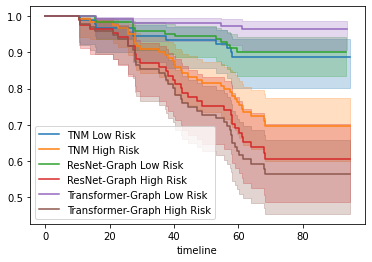

In [24]:
# Stage as reference
Ts1 = feature_dfn_test[feature_dfn_test['TNM']==0]['OS_Month']
Es1 = feature_dfn_test[feature_dfn_test['TNM']==0]['OS_Status']
kmfs1 = KaplanMeierFitter(label="TNM Low Risk")
kmfs1.fit(Ts1, Es1)
kmfs1.survival_function_
kmfs1.cumulative_density_
kmfs1.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()

Ts2 = feature_dfn_test[feature_dfn_test['TNM']==1]['OS_Month']
Es2 = feature_dfn_test[feature_dfn_test['TNM']==1]['OS_Status']
kmfs2 = KaplanMeierFitter(label="TNM High Risk")
kmfs2.fit(Ts2, Es2)
kmfs2.survival_function_
kmfs2.cumulative_density_
kmfs2.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()
stage_results=logrank_test(Ts1,Ts2,event_observed_A=Es1, event_observed_B=Es2)
stage_results.print_summary()

# 
Tr1 = feature_dfn_test[feature_dfn_test['resnet_risk_labels']==0]['OS_Month']
Er1 = feature_dfn_test[feature_dfn_test['resnet_risk_labels']==0]['OS_Status']
kmfr1 = KaplanMeierFitter(label="ResNet-Graph Low Risk")
kmfr1.fit(Tr1, Er1)
kmfr1.survival_function_
kmfr1.cumulative_density_
kmfr1.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()

Tr2 = feature_dfn_test[feature_dfn_test['resnet_risk_labels']==1]['OS_Month']
Er2 = feature_dfn_test[feature_dfn_test['resnet_risk_labels']==1]['OS_Status']
kmfr2 = KaplanMeierFitter(label="ResNet-Graph High Risk")
kmfr2.fit(Tr2, Er2)
kmfr2.survival_function_
kmfr2.cumulative_density_
kmfr2.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()
res_results=logrank_test(Tr1,Tr2,event_observed_A=Es1, event_observed_B=Es2)
res_results.print_summary()

# Our Model
TGCN_low = feature_dfn_test[feature_dfn_test['risk_labels']==0]['OS_Month']
EGCN_low = feature_dfn_test[feature_dfn_test['risk_labels']==0]['OS_Status']
kmGCN_low = KaplanMeierFitter(label="Transformer-Graph Low Risk")
kmGCN_low.fit(TGCN_low, EGCN_low)
kmGCN_low.survival_function_
kmGCN_low.cumulative_density_
kmGCN_low.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()

TGCN_high = feature_dfn_test[feature_dfn_test['risk_labels']==1]['OS_Month']
EGCN_high = feature_dfn_test[feature_dfn_test['risk_labels']==1]['OS_Status']
kmGCN_high = KaplanMeierFitter(label="Transformer-Graph High Risk")
kmGCN_high.fit(TGCN_high, EGCN_high)
kmGCN_high.survival_function_
kmGCN_high.cumulative_density_
kmGCN_high.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()
gcn_results=logrank_test(TGCN_low,TGCN_high,event_observed_A=EGCN_low, event_observed_B=EGCN_high)
gcn_results.print_summary()

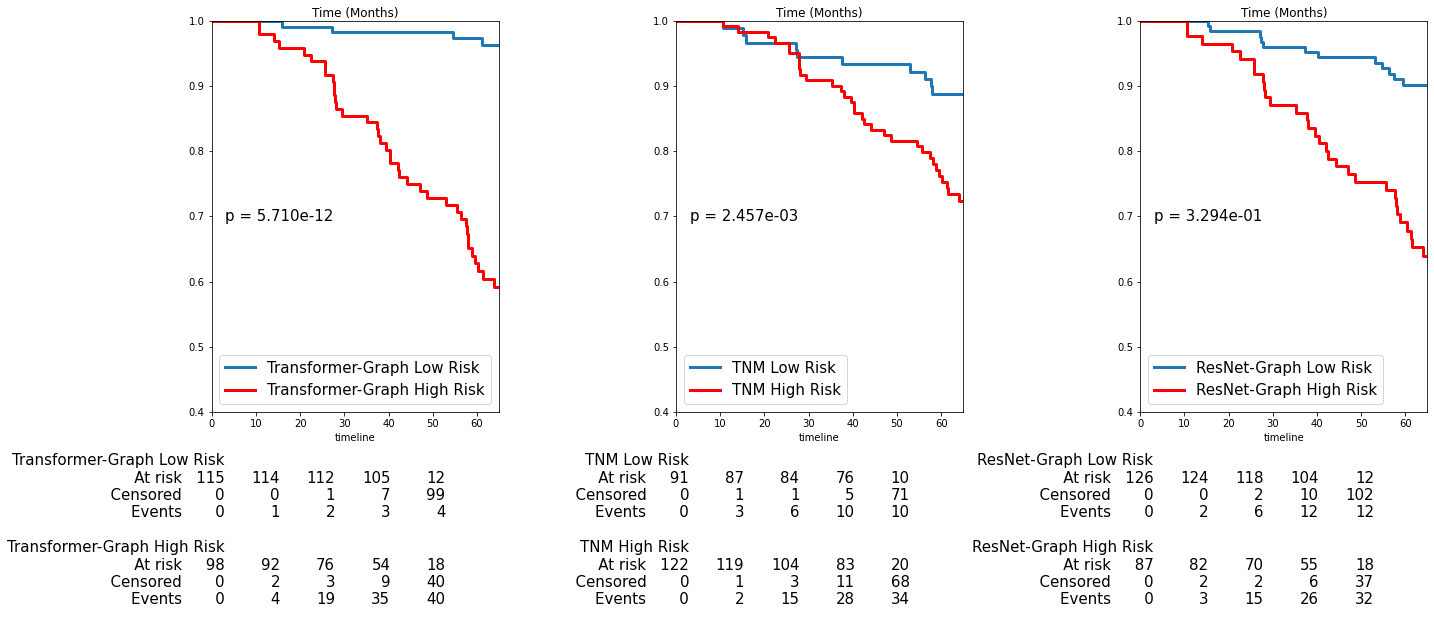

In [25]:
fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(131)
kmGCN_low.plot_survival_function(ci_show =False, lw=3)
kmGCN_high.plot_survival_function(ci_show =False, color='r', lw=3)
add_at_risk_counts(kmGCN_low, kmGCN_high, ax=ax1)

# ax1.title.set_text('Transformer Graph Model Kaplan-Meier Curve ')
# ax1.title.set_fontsize(15)
ax1.set_ylim([0.4, 1.0])
ax1.set_xlim([0.0, 65.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time (Months)', size = 12)
p1 = gcn_results.p_value
ax1.add_artist(AnchoredText("p = %.3e" % round(p1, 15), loc=6, prop=dict(size=15),frameon=False))
# ax1.title("GCN Kaplan-Meier Curve")
ax1.legend(loc='lower left',prop={'size': 15})


ax2 =  fig.add_subplot(132)
kmfs1.plot_survival_function(ci_show =False, lw=3)
kmfs2.plot_survival_function(ci_show =False, color='r', lw=3)
add_at_risk_counts(kmfs1, kmfs2, ax=ax2)
# ax2.title.set_text('TNM Model Kaplan-Meier Curve ')
# ax2.title.set_fontsize(15)
ax2.set_ylim([0.4, 1.0])
ax2.set_xlim([0.0, 65.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time (Months)', size = 12)
p2 = stage_results.p_value
ax2.add_artist(AnchoredText("p = %.3e" % round(p2,10 ), loc=6, prop=dict(size=15),frameon=False))
ax2.legend(loc='lower left',prop={'size': 15})


ax3 =  fig.add_subplot(133)
kmfr1.plot_survival_function(ci_show =False, lw=3)
kmfr2.plot_survival_function(ci_show =False, color='r', lw=3)
add_at_risk_counts(kmfr1, kmfr2, ax=ax3)
# ax3.title.set_text('ResNet-Graph Kaplan-Meier Curve ')
# ax3.title.set_fontsize(15)
ax3.set_ylim([0.4, 1.0])
ax3.set_xlim([0.0, 65.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time (Months)', size = 12)
p3 = res_results.p_value
ax3.add_artist(AnchoredText("p = %.3e" % round(p3,10 ), loc=6,  prop=dict(size=15),frameon=False))
ax3.legend(loc='lower left',prop={'size': 15})

plt.tight_layout()
plt.show()
fig.savefig('KMcurve.jpg', bbox_inches='tight', dpi=350)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           5.22 0.02      5.49

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.31 0.58      0.79

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          38.99 <0.005     31.13

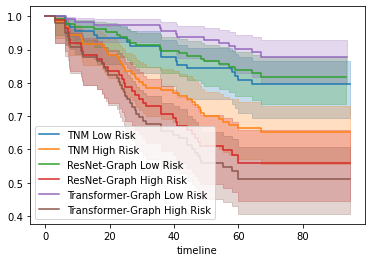

In [26]:
# Stage as reference
Ts1 = feature_dfn_test[feature_dfn_test['TNM']==0]['RFS_Month']
Es1 = feature_dfn_test[feature_dfn_test['TNM']==0]['RFS_Status']
kmfs1 = KaplanMeierFitter(label="TNM Low Risk")
kmfs1.fit(Ts1, Es1)
kmfs1.survival_function_
kmfs1.cumulative_density_
kmfs1.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()

Ts2 = feature_dfn_test[feature_dfn_test['TNM']==1]['RFS_Month']
Es2 = feature_dfn_test[feature_dfn_test['TNM']==1]['RFS_Status']
kmfs2 = KaplanMeierFitter(label="TNM High Risk")
kmfs2.fit(Ts2, Es2)
kmfs2.survival_function_
kmfs2.cumulative_density_
kmfs2.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()
stage_results=logrank_test(Ts1,Ts2,event_observed_A=Es1, event_observed_B=Es2)
stage_results.print_summary()

# 
Tr1 = feature_dfn_test[feature_dfn_test['resnet_risk_labels']==0]['RFS_Month']
Er1 = feature_dfn_test[feature_dfn_test['resnet_risk_labels']==0]['RFS_Status']
kmfr1 = KaplanMeierFitter(label="ResNet-Graph Low Risk")
kmfr1.fit(Tr1, Er1)
kmfr1.survival_function_
kmfr1.cumulative_density_
kmfr1.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()

Tr2 = feature_dfn_test[feature_dfn_test['resnet_risk_labels']==1]['RFS_Month']
Er2 = feature_dfn_test[feature_dfn_test['resnet_risk_labels']==1]['RFS_Status']
kmfr2 = KaplanMeierFitter(label="ResNet-Graph High Risk")
kmfr2.fit(Tr2, Er2)
kmfr2.survival_function_
kmfr2.cumulative_density_
kmfr2.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()
res_results=logrank_test(Tr1,Tr2,event_observed_A=Es1, event_observed_B=Es2)
res_results.print_summary()

# Our Model
TGCN_low = feature_dfn_test[feature_dfn_test['risk_labels']==0]['RFS_Month']
EGCN_low = feature_dfn_test[feature_dfn_test['risk_labels']==0]['RFS_Status']
kmGCN_low = KaplanMeierFitter(label="Transformer-Graph Low Risk")
kmGCN_low.fit(TGCN_low, EGCN_low)
kmGCN_low.survival_function_
kmGCN_low.cumulative_density_
kmGCN_low.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()

TGCN_high = feature_dfn_test[feature_dfn_test['risk_labels']==1]['RFS_Month']
EGCN_high = feature_dfn_test[feature_dfn_test['risk_labels']==1]['RFS_Status']
kmGCN_high = KaplanMeierFitter(label="Transformer-Graph High Risk")
kmGCN_high.fit(TGCN_high, EGCN_high)
kmGCN_high.survival_function_
kmGCN_high.cumulative_density_
kmGCN_high.plot_survival_function(ci_show =True)
# kmf2.plot_cumulative_density()
gcn_results=logrank_test(TGCN_low,TGCN_high,event_observed_A=EGCN_low, event_observed_B=EGCN_high)
gcn_results.print_summary()

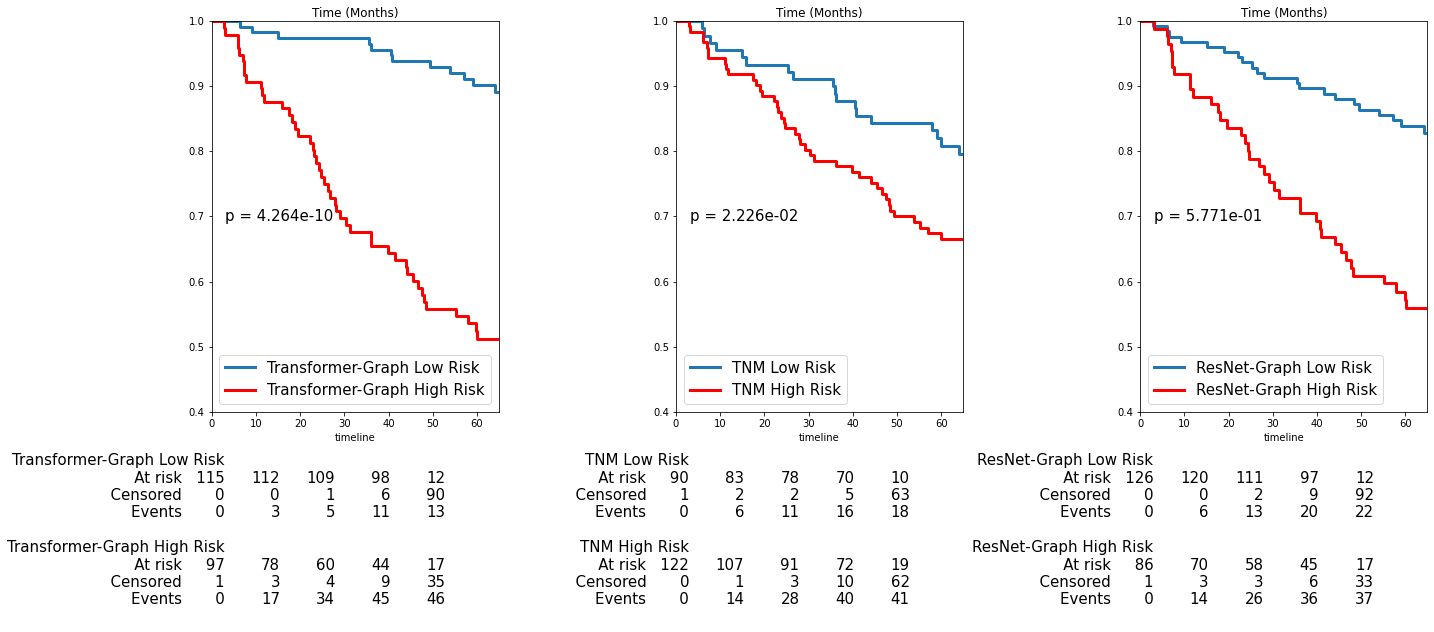

In [27]:
fig = plt.figure(figsize=(20,9))

ax1 = fig.add_subplot(131)
kmGCN_low.plot_survival_function(ci_show =False, lw=3)
kmGCN_high.plot_survival_function(ci_show =False, color='r', lw=3)
add_at_risk_counts(kmGCN_low, kmGCN_high, ax=ax1)

# ax1.title.set_text('Transformer-Graph Model Kaplan-Meier Curve ')
# ax1.title.set_fontsize(15)
ax1.set_ylim([0.4, 1.0])
ax1.set_xlim([0.0, 65.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time (Months)', size = 12)
p1 = gcn_results.p_value
ax1.add_artist(AnchoredText("p = %.3e" % round(p1, 15), loc=6,  prop=dict(size=15),frameon=False))
# ax1.title("GCN Kaplan-Meier Curve")
ax1.legend(loc='lower left',prop={'size': 15})


ax2 =  fig.add_subplot(132)
kmfs1.plot_survival_function(ci_show =False, lw=3)
kmfs2.plot_survival_function(ci_show =False, color='r', lw=3)
add_at_risk_counts(kmfs1, kmfs2, ax=ax2)
# ax2.title.set_text('TNM Model Kaplan-Meier Curve ')
# ax2.title.set_fontsize(15)
ax2.set_ylim([0.4, 1.0])
ax2.set_xlim([0.0, 65.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time (Months)', size = 12)
p2 = stage_results.p_value
ax2.add_artist(AnchoredText("p = %.3e" % round(p2,10 ), loc=6,  prop=dict(size=15),frameon=False))
ax2.legend(loc='lower left',prop={'size': 15})


ax3 =  fig.add_subplot(133)
kmfr1.plot_survival_function(ci_show =False, lw=3)
kmfr2.plot_survival_function(ci_show =False, color='r', lw=3)
add_at_risk_counts(kmfr1, kmfr2, ax=ax3)
# ax3.title.set_text('ResNet-Graph Kaplan-Meier Curve ')
# ax3.title.set_fontsize(15)
ax3.set_ylim([0.4, 1.0])
ax3.set_xlim([0.0, 65.0])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Time (Months)', size = 12)
p3 = res_results.p_value
ax3.add_artist(AnchoredText("p = %.3e" % round(p3,10 ), loc=6,  prop=dict(size=15),frameon=False))
ax3.legend(loc='lower left',prop={'size': 15})

plt.tight_layout()
plt.show()
fig.savefig('RFS_KMcurve.jpg', bbox_inches='tight', dpi=350)

<lifelines.CoxPHFitter: fitted with 213 total observations, 169 right-censored observations>
             duration col = 'OS_Month'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 213
number of events observed = 44
   partial log-likelihood = -215.82
         time fit was run = 2022-02-16 05:06:54 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
risk        3.94      51.31       0.72             2.53             5.35                12.55               209.73

             z      p   -log2(p)
covariate                       
risk      5.48 <0.005      24.50
---
Concordance = 0.75
Partial AIC = 433.63
log-likelihood ratio test = 25.69 on 1 df
-log2(p) of ll-ratio test = 21.25

ICI =  0.023074468491257962
E50 =  0.014474899968279664


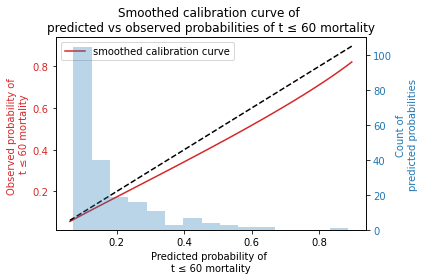

In [27]:
GCN_cox = feature_dfn_test[['OS_Month','OS_Status', 'risk']]
cph_GCN = CoxPHFitter()
cph_GCN.fit(GCN_cox, 'OS_Month', event_col='OS_Status')
cph_GCN.print_summary()
y_gcn =cph_GCN.predict_partial_hazard(GCN_cox)
axGCN, ICI, E50 = calibration.survival_probability_calibration(cph_GCN, GCN_cox, t0=60)

ICI =  0.06293358374028092
E50 =  0.06051677528211197


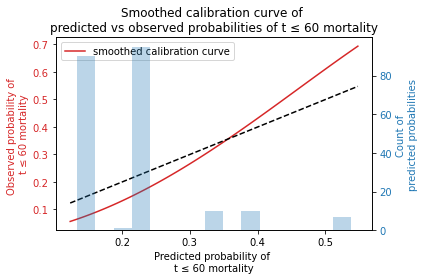

In [28]:
ax_stage, ICI, E50 = calibration.survival_probability_calibration(cph_c, patient_dfn_test, t0=60)

In [18]:
# draw plots
import json
from networkx.readwrite import json_graph
from pyvis.network import Network


In [19]:
with open('logs/results/data.json' ) as f:
    data = json.load(f)
    
graph_data = json.loads(data)
graph = json_graph.node_link_graph(graph_data)
graph.remove_edges_from(nx.selfloop_edges(graph))
graph_gt = graph.copy()

In [20]:
for i in range(len(graph.nodes)):
    if graph.nodes[i]['Risk_Label'] == -1:
        graph.nodes[i]['label'] = "low risk"
        graph.nodes[i]['color'] = "#87CEFA"
    else:
        graph.nodes[i]['label'] = "high risk"
        graph.nodes[i]['color'] = "#FFC0CB"

In [21]:
for i in range(len(graph_gt.nodes)):
    if graph_gt.nodes[i]['E'] == 0:
        graph_gt.nodes[i]['label'] = "Survival"
        graph_gt.nodes[i]['color'] = "#1E90FF"
    else:
        graph_gt.nodes[i]['label'] = "Death"
        graph_gt.nodes[i]['color'] = "#FF4500"

In [114]:
ntg = Network("1000px", "1000px")
ntg.show_buttons(filter_=['physics'])
ntg.from_nx(graph_gt)
ntg.show("nx_gt.html")

In [22]:
subgs = np.load('subg.npy', allow_pickle=True)

In [23]:
def seacg_g(idx):

    for gr in subgs:
        if idx in gr:
            return gr

In [24]:
subg1 = seacg_g(204)

In [26]:
inter_test = feature_dfn_test.iloc[list(subg1),:]

In [27]:

# # Our Model
# TGCN_low = inter_test[inter_test['risk_labels']==0]['OS_Month']
# EGCN_low = inter_test[inter_test['risk_labels']==0]['OS_Status']
# kmGCN_low = KaplanMeierFitter(label="Transformer-Graph Low Risk")
# kmGCN_low.fit(TGCN_low, EGCN_low)
# kmGCN_low.survival_function_
# kmGCN_low.cumulative_density_
# kmGCN_low.plot_survival_function(ci_show =True)
# # kmf2.plot_cumulative_density()

# TGCN_high = inter_test[inter_test['risk_labels']==1]['OS_Month']
# EGCN_high = inter_test[inter_test['risk_labels']==1]['OS_Status']
# kmGCN_high = KaplanMeierFitter(label="Transformer-Graph High Risk")
# kmGCN_high.fit(TGCN_high, EGCN_high)
# kmGCN_high.survival_function_
# kmGCN_high.cumulative_density_
# kmGCN_high.plot_survival_function(ci_show =True)
# # kmf2.plot_cumulative_density()
# gcn_results=logrank_test(TGCN_low,TGCN_high,event_observed_A=EGCN_low, event_observed_B=EGCN_high)
# gcn_results.print_summary()

In [28]:
# fig = plt.figure(figsize=(5,5))
# ax1 = fig.add_subplot(111)
# kmGCN_low.plot_survival_function(ci_show =False, lw=3)
# kmGCN_high.plot_survival_function(ci_show =False, color='r', lw=3)
# # add_at_risk_counts(kmGCN_low, kmGCN_high, ax=ax1)

# # ax1.title.set_text('Transformer-Graph Model Kaplan-Meier Curve ')
# # ax1.title.set_fontsize(15)
# ax1.set_ylim([0.3, 1.05])
# ax1.set_xlim([0.0, 65.0])
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# p1 = gcn_results.p_value
# ax1.add_artist(AnchoredText("p = %.3e" % round(p1, 15), loc=4,  prop=dict(size=10),frameon=False))
# # ax1.title("GCN Kaplan-Meier Curve")
# ax1.legend(loc='lower left',prop={'size': 10})
# fig.savefig('KM_test_g2.png', bbox_inches='tight', dpi=350)

In [33]:
inter_test

,pT_Stage,pN_Stage,pM_Stage,RFS_Month,RFS_Status,OS_Month,OS_Status,risk,risk_labels,ResNet_risk,resnet_risk_labels
355,0,0,0,61.000000,0,61.000000,0,2.081852,0,0.004220,0
47,1,0,0,68.866667,0,68.866667,0,2.080016,0,0.021983,1
1283,0,0,0,68.633333,0,68.633333,0,2.039209,0,0.021051,1
1027,0,0,0,79.600000,0,79.600000,0,2.046938,0,0.013033,0
220,0,0,0,6.433333,1,27.100000,1,2.106150,0,0.016566,0
493,1,0,0,82.833333,0,82.833333,0,2.063257,0,0.014007,0
1078,1,0,0,70.900000,0,70.900000,0,2.143966,0,0.015476,0
291,1,0,0,93.866667,0,93.866667,0,2.067533,0,0.022107,1
948,0,0,0,64.133333,1,71.266667,0,2.145666,0,0.012371,0
1140,0,0,1,0.000000,0,10.666667,1,2.298171,1,0.029858,1
